# Project SKIMLIT 📖 🔥 :
Purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

## Confirm access to GPU

In [1]:
!nvidia-smi

Sat Jan 28 20:04:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data
PubMed 200K RCT

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 13.13 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in pubmed-rct 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments with 20k dataset with numers replaced with @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the directory
import os
filenames = [data_dir + filenames for filenames in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data 
Now we have got some text data its time to become one with the data
so lets write a function to read in all the lines of text file

In [6]:
# Create a function to read the lines of a document
def get_lines (filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
# Lets read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines within training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
# def get_data(train_lines):
#  list_dict=[]
#  line_numbers=[]
#  targets=[]
#  for i in range (len(train_lines)):
#    if "\t" in train_lines[i]:
#      line_numbers.append(i)
#      targets.append(train_lines[i].split(sep="\t"))
#    else:
#      if train_lines[i] == "\n":
#        for e in range (len(targets)):
#          list_dict.append({"line_number":e,
#                            "target":targets[e][0],
#                            "text":targets[e][1],
#                            "total_lines":len(targets)-1})
#  return(list_dict)

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples
     

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir +"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 401 ms, sys: 79.4 ms, total: 481 ms
Wall time: 484 ms


In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

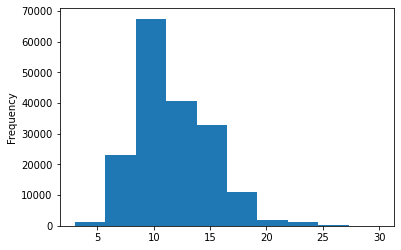

In [14]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [15]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels

In [17]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Tensorflow is incompatible with sparse metrix

In [18]:
import tensorflow as tf


In [19]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like 
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script 

In [24]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2023-01-28 20:04:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-28 20:04:44 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                      y_pred=baseline_preds)

In [27]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text)for deep sequence model

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
# How long is each sentence on average 
sent_lens = [len(sentence.split())for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

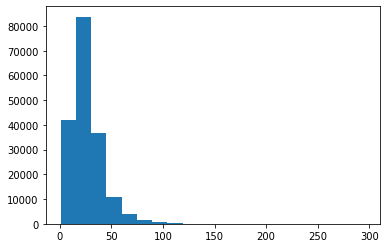

In [30]:
# Whats the ditribution look like
import matplotlib.pyplot as plt 
plt.hist(sent_lens,bins=20);

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len


55

In [32]:
# Macimum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer 

In [33]:
# How many words are in our vocab
max_token = 68000

In [34]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_token, # Number of words in vocab
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence} ")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
a sensitivity analysis revealed a positive significant intervention effect of pa in recess with an adjusted difference of @ cpm . 

Length of text: 129

Vectorized text: [[   8  509   85  782    8  280   37   38   70    4 1067    5 8591    7
    26  411   74    4 4664    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero=True,
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded setences shape: {embedded_sentence.shape}")

Sentence before vectorization:
 a sensitivity analysis revealed a positive significant intervention effect of pa in recess with an adjusted difference of @ cpm .
Sentence after vectorization (before embedding):
[[   8  509   85  782    8  280   37   38   70    4 1067    5 8591    7
    26  411   74    4 4664    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.01334926  0.04359731  0.00653968 ...  0.01115181 -0.00416198
   -0.00952113]
  [-0.00788695 -0.01360546 -0.04627656 ... -0.03654819  0.02029884
    0.04825132]
  [-0.01031496 -0.03255903 -0.0496536  ...  0.03308636 -0.00082871
   -0.02586706]
  ...
  [-0.03119483 -0.01965848 -0.03550427 ...  0.01113188  0.00070907
   -0.01543553]
  [-0.03119483 -0.01965848 -0.03550427 ...  0.01113188  0.00070907
   -0.01543553]
  [-0.03119483 -0.01965848 -0.03550427 ...  0.01113188  

## Creating datasets making sure our data load fast

In [41]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the tensorslicedataset and turn them into prefetch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model_1 : Conv 1D with token embeddings

In [43]:
# Create 1D conv model to process sequence
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [45]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 13ms/step - loss: 0.9218 - accuracy: 0.6365 - val_loss: 0.6879 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6629 - accuracy: 0.7514 - val_loss: 0.6389 - val_accuracy: 0.7650
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6225 - accuracy: 0.7699 - val_loss: 0.5978 - val_accuracy: 0.7839


In [46]:
# Evaluate on all od validation datasets
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6005 - accuracy: 0.7860


[0.6005153656005859, 0.786045253276825]

In [47]:
# Make predictions (our model prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.1500613e-01, 1.7883918e-01, 7.3865645e-02, 3.0345401e-01,
         2.8835073e-02],
        [4.5146334e-01, 2.7042007e-01, 1.4772760e-02, 2.5510931e-01,
         8.2344431e-03],
        [1.9622590e-01, 1.0313060e-02, 2.2688222e-03, 7.9112655e-01,
         6.5740358e-05],
        ...,
        [3.4278498e-06, 5.2328123e-04, 6.2069518e-04, 3.1728564e-06,
         9.9884939e-01],
        [6.0020238e-02, 4.4665766e-01, 1.0455758e-01, 7.6227888e-02,
         3.1253654e-01],
        [1.7030130e-01, 6.4568555e-01, 5.2107029e-02, 5.3092036e-02,
         7.8814007e-02]], dtype=float32), (30212, 5))

In [48]:
# Covert pred probs to classes 
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60452800211837,
 'precision': 0.7825176641726157,
 'recall': 0.7860452800211837,
 'f1': 0.7834752066046816}

In [50]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2 Feature extraction with pretrained token embedding

In [51]:
# Download pretrianed Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name = "universal_sentence_encoder")

In [52]:
# Test our pretrined embedding on a random setence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")

Random sentence:
 in the resiniferatoxin group , the effective rate of patients with redundant prepuce was @ % , and both the intravaginal ejaculation latency time and chinese index of sexual function for premature ejaculation-@ significantly increased ( p < @ ) .
Sentence after embedding:
[ 0.03180861  0.00225421 -0.02165939  0.00593066 -0.00151708  0.04936504
 -0.00520536 -0.056123    0.06716335  0.03825828  0.06558282  0.01435051
  0.05641232  0.04654407  0.06584113 -0.03750423 -0.07184398  0.02075226
 -0.02965695  0.06189814 -0.01929908  0.02762948 -0.07115662 -0.01884574
  0.02640794  0.02313605  0.01096252  0.03559465 -0.0697355  -0.02777866]

Length of sentence embedding:512


## Building feature extraction model using TF Hub layer

In [53]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
# Note: you could add some layer here
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name="model_2_USE_feature_extractor")
# Compile the model
model_2.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
# fit model_2 to the data
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset)),
            epochs=3)

Epoch 1/3
562/562 [==============================] - 17s 22ms/step - loss: 0.9196 - accuracy: 0.6506 - val_loss: 0.7984 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7698 - accuracy: 0.7012 - val_loss: 0.7555 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7540 - accuracy: 0.7112 - val_loss: 0.7401 - val_accuracy: 0.7134


In [56]:
# Evaluate on the whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7428 - accuracy: 0.7141


[0.7427902221679688, 0.7141202092170715]

In [57]:
# Make some predictions with our feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.7004968e-01, 3.2003272e-01, 2.2454495e-03, 1.9946395e-01,
        8.2082665e-03],
       [3.6986524e-01, 4.7815222e-01, 3.3338126e-03, 1.4595896e-01,
        2.6898677e-03],
       [2.3086077e-01, 1.5123947e-01, 2.0416362e-02, 5.6045628e-01,
        3.7027095e-02],
       ...,
       [1.8722184e-03, 6.0965256e-03, 6.1479833e-02, 8.1763725e-04,
        9.2973381e-01],
       [4.3964293e-03, 4.9734026e-02, 1.9690762e-01, 1.4770161e-03,
        7.4748492e-01],
       [2.0914553e-01, 2.3817867e-01, 4.7630239e-01, 1.0990297e-02,
        6.5383181e-02]], dtype=float32)

In [58]:
# Convert the pridiction probabilities to labels
model_2_preds = np.argmax(model_2_pred_probs,axis=1)
model_2_preds

array([0, 1, 3, ..., 4, 4, 2])

In [59]:
# Calculate results of Feature extraction model
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.41202171322654,
 'precision': 0.7142550372434562,
 'recall': 0.7141202171322654,
 'f1': 0.7110665882546316}

In [60]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

### We need to create a chaacter level embedding 

In [61]:
# Make a function to split sentences into character
def split_chars(text):
  return " ".join(list(text))
# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n   t h e   r e s i n i f e r a t o x i n   g r o u p   ,   t h e   e f f e c t i v e   r a t e   o f   p a t i e n t s   w i t h   r e d u n d a n t   p r e p u c e   w a s   @   %   ,   a n d   b o t h   t h e   i n t r a v a g i n a l   e j a c u l a t i o n   l a t e n c y   t i m e   a n d   c h i n e s e   i n d e x   o f   s e x u a l   f u n c t i o n   f o r   p r e m a t u r e   e j a c u l a t i o n - @   s i g n i f i c a n t l y   i n c r e a s e d   (   p   <   @   )   .'

In [62]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [63]:
# Whats the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

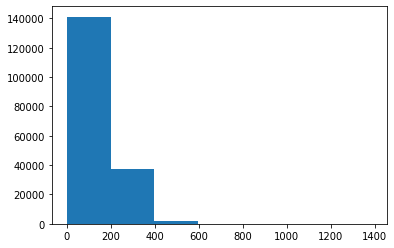

In [64]:
# Check the distribution of our sequence at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [65]:
# Find what character length covers 95 % of the sequence 
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [66]:
# get all keyboard characters
import string 
alphabet = string.ascii_lowercase +string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [67]:
# Create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) +2 # add 2 for space and oov token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name="char_vectorizer")

In [68]:
# Adapt charachter vectorizer to out training characters
char_vectorizer.adapt(train_chars)

In [69]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"number of different characters in vocab: {len(char_vocab)}")
print(f"5 most common chaachters: {char_vocab[:5]}")
print(f"5 least common charachters: {char_vocab[-5:]}")

number of different characters in vocab: 28
5 most common chaachters: ['', '[UNK]', 'e', 't', 'i']
5 least common charachters: ['k', 'x', 'z', 'q', 'j']


you can also play with the standardization argument

In [70]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"vectorized chars:\n {vectorized_chars}")
print(f"Length of vectorized chars:{len(vectorized_chars[0])} ")

Charified text:
 t h i r t y   p a t i e n t s   w i t h   c k d   w e r e   e v a l u a t e d   .
Length of random_train_chars: 35
vectorized chars:
 [[ 3 13  4  8  3 19 14  5  3  4  2  6  3  9 20  4  3 13 11 23 10 20  2  8
   2  2 21  5 12 16  5  3  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0 

In [71]:
## Creating a character level embedding 
char_embed = layers.Embedding(input_dim=len(char_vocab),
                             output_dim=25,
                             mask_zero=True,
                             name="char_embed")

In [72]:
# Test out character ebedding layer 
print(f"charified text:\ {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding:\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

charified text:\ t h i r t y   p a t i e n t s   w i t h   c k d   w e r e   e v a l u a t e d   .

Embedded chars. (after vectorization and embedding:
 [[[-0.00756454 -0.0071702  -0.0320333  ...  0.01157055 -0.03292789
    0.02697979]
  [ 0.02169294  0.03736329  0.04843191 ...  0.0139106   0.04661779
   -0.04896211]
  [ 0.00768846 -0.01236568  0.03278888 ... -0.01708965  0.03107842
   -0.02522365]
  ...
  [-0.01529424 -0.04530982 -0.01243553 ... -0.04888672  0.04289753
    0.01376606]
  [-0.01529424 -0.04530982 -0.01243553 ... -0.04888672  0.04289753
    0.01376606]
  [-0.01529424 -0.04530982 -0.01243553 ... -0.04888672  0.04289753
    0.01376606]]]
Character embedding shape: (1, 290, 25)


In [73]:
len(random_train_chars)

81

## Building a Conv1D model to fit on character embeddings

In [74]:
# Make Conv1D on chars only 
inputs = layers.Input(shape=(1,),dtype="string")
char_vectors = char_vectorizer(inputs)
token_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,outputs=outputs,name="model_3_conv1d_char_embeddings")

# Compile 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [76]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
# Create char level datasets
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [77]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)),
                              )

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2700 - accuracy: 0.4953 - val_loss: 1.0423 - val_accuracy: 0.5911
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9984 - accuracy: 0.6025 - val_loss: 0.9270 - val_accuracy: 0.6463
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9091 - accuracy: 0.6470 - val_loss: 0.8584 - val_accuracy: 0.6745


In [78]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.1554003 , 0.5656255 , 0.04457042, 0.22050107, 0.01390273],
       [0.22878744, 0.5534198 , 0.00355584, 0.19863583, 0.01560114],
       [0.17634223, 0.21037222, 0.09304683, 0.47613832, 0.04410035],
       ...,
       [0.02525512, 0.03191321, 0.18315606, 0.06370933, 0.69596624],
       [0.07363945, 0.17176883, 0.35510585, 0.09084898, 0.30863687],
       [0.30760837, 0.6014875 , 0.02400909, 0.04628798, 0.02060708]],
      dtype=float32)

In [79]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [80]:
# Calculate results for Conv1D model chars
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)

In [81]:
model_3_results

{'accuracy': 66.31801933006753,
 'precision': 0.6583235245894916,
 'recall': 0.6631801933006752,
 'f1': 0.6534463545194034}

In [82]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Word embeddings + Character embeddings

structure a model which takes token and character level sequences as input and produces sequence label probabilities as output

In [83]:
# 1. setup token inputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. setup char inputs / model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Combine both models using concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers adding in dropouts
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

#5. Construct a model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")

In [84]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

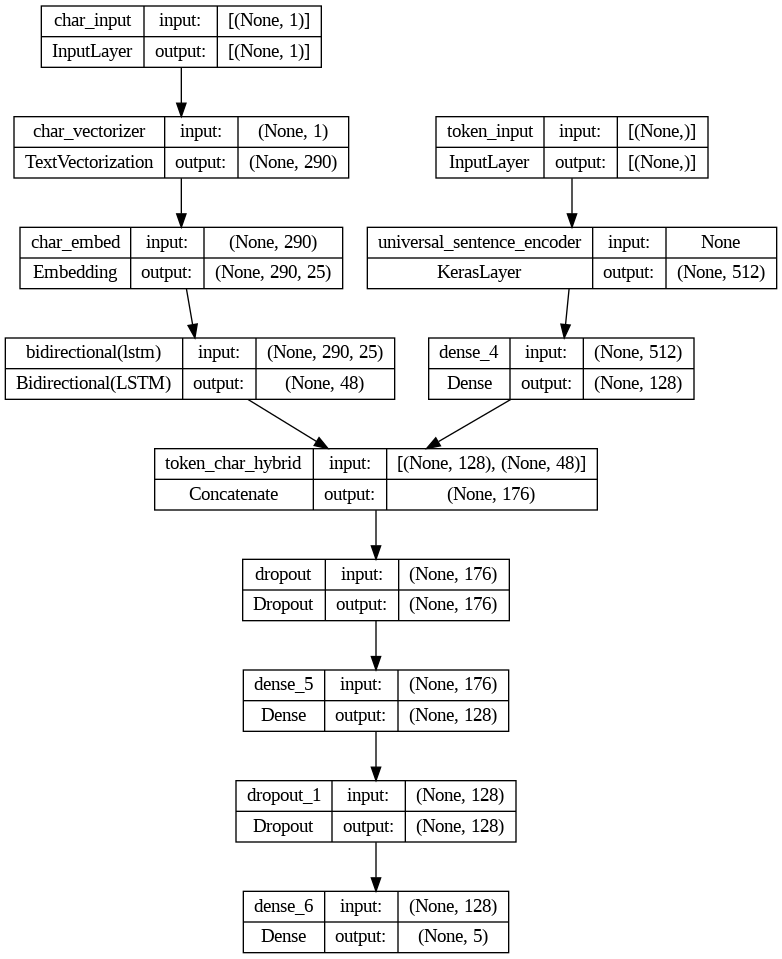

In [85]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [86]:
# Compile token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Datast

In [87]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data,train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [88]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data,val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [89]:
# Check out the datasets
train_char_token_dataset,val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting the model on token and character level sequences

In [90]:
# Fit the model to token and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 55ms/step - loss: 0.9854 - accuracy: 0.6082 - val_loss: 0.7831 - val_accuracy: 0.6995
Epoch 2/3
562/562 [==============================] - 33s 58ms/step - loss: 0.7995 - accuracy: 0.6910 - val_loss: 0.7126 - val_accuracy: 0.7364
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7715 - accuracy: 0.7050 - val_loss: 0.6839 - val_accuracy: 0.7390


In [91]:
# Make predictions using model_4
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 25s 23ms/step


array([[4.2120472e-01, 3.9631084e-01, 6.1193467e-03, 1.6532159e-01,
        1.1043396e-02],
       [3.1176302e-01, 5.4207814e-01, 3.6562402e-03, 1.4121869e-01,
        1.2839005e-03],
       [2.8666902e-01, 1.8105321e-01, 6.4409219e-02, 4.1438505e-01,
        5.3483475e-02],
       ...,
       [4.2507800e-04, 6.7340834e-03, 6.1935794e-02, 1.7800077e-04,
        9.3072712e-01],
       [4.8371172e-03, 4.4667445e-02, 2.9819837e-01, 2.2226586e-03,
        6.5007436e-01],
       [1.9213909e-01, 4.1596973e-01, 2.6935464e-01, 3.2580003e-02,
        8.9956492e-02]], dtype=float32)

In [92]:
# Convert model_4_pred_probs to predictions
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)

In [93]:
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [94]:
# Calculate model_4_results
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)

In [95]:
model_4_results

{'accuracy': 73.4708063021316,
 'precision': 0.7362303531315971,
 'recall': 0.7347080630213161,
 'f1': 0.7303374353428107}

## Model 5: Transfer learning with pretrained token embeddings + Character embedding

Any engineered feature should be available at test time

### Create positional embeddings

In [96]:
# How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

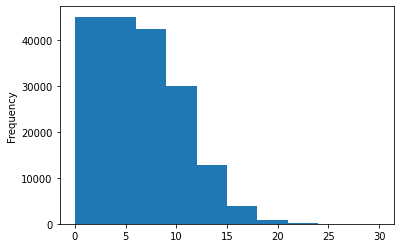

In [97]:
# Check the distribution of line number column
train_df.line_number.plot.hist()

In [98]:
# use Tensorflow to create one-hot-encoded tensor of our lin number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [99]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

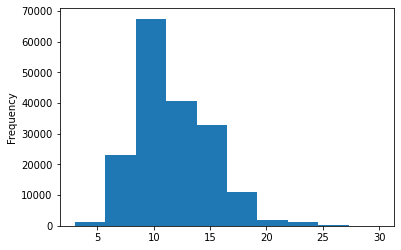

In [100]:
train_df["total_lines"].plot.hist();


In [101]:
# use Tensorflow to create one-hot-encoded tensor of our lin number column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot[:10],train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

In [107]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")
     

In [108]:
# Get model 5 summary
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

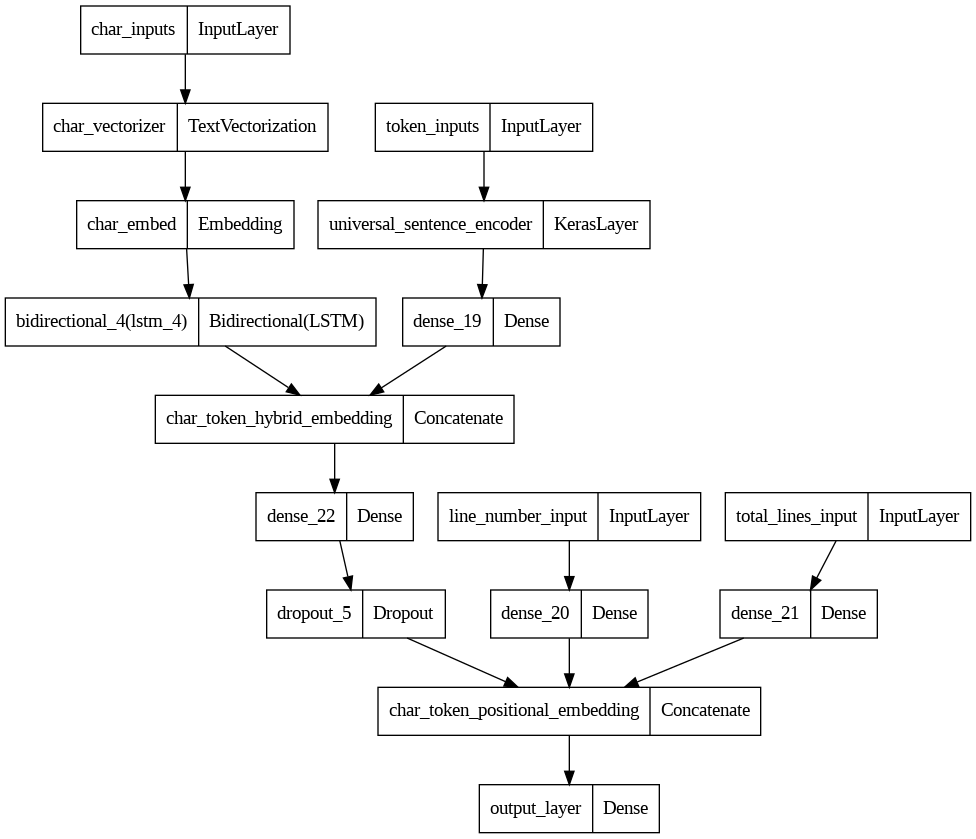

In [113]:
# Plot model 5
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [115]:
# Compile token char and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding dataset using tf.data

In [ ]:
train_line_numbers_one_hot, train_total_lines_one_hot

In [116]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
     

In [117]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predicitions with our tribrid model

In [118]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))
     

Epoch 1/3
562/562 [==============================] - 42s 60ms/step - loss: 1.0983 - accuracy: 0.7202 - val_loss: 0.9802 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.9663 - accuracy: 0.8174 - val_loss: 0.9494 - val_accuracy: 0.8258
Epoch 3/3
562/562 [==============================] - 29s 52ms/step - loss: 0.9499 - accuracy: 0.8249 - val_loss: 0.9364 - val_accuracy: 0.8348


In [119]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs
     

945/945 [==============================] - 25s 24ms/step


array([[0.4660216 , 0.10444139, 0.01105887, 0.40031502, 0.01816312],
       [0.53488386, 0.09791265, 0.04401587, 0.31267777, 0.01050989],
       [0.2478112 , 0.12441313, 0.1436284 , 0.41550997, 0.06863727],
       ...,
       [0.03187098, 0.09155907, 0.03873225, 0.02814104, 0.8096967 ],
       [0.03188712, 0.26659042, 0.09101874, 0.0313008 , 0.57920295],
       [0.21011356, 0.5929847 , 0.08985889, 0.04212454, 0.06491836]],
      dtype=float32)

In [120]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [121]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results
     

{'accuracy': 83.29802727393088,
 'precision': 0.8316114344747414,
 'recall': 0.8329802727393089,
 'f1': 0.8320142170655527}

## Compare model results

In [122]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.604528,0.782518,0.786045,0.783475
model_2_pretrained_token_embedding,71.412022,0.714255,0.714120,0.711067
model_3_custom_char_embedding,66.318019,0.658324,0.663180,0.653446
model_4_hybrid_char_token_embedding,73.470806,0.736230,0.734708,0.730337
model_5_pos_char_token_embedding,83.298027,0.831611,0.832980,0.832014


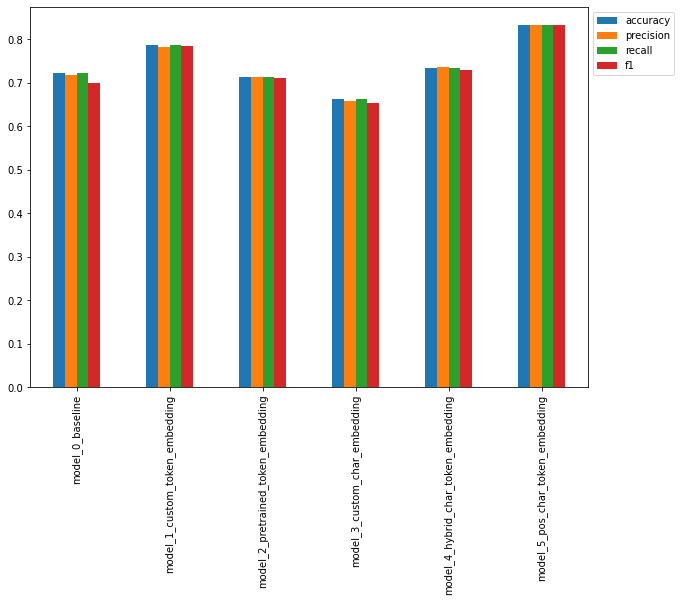

In [123]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
     

# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));
     

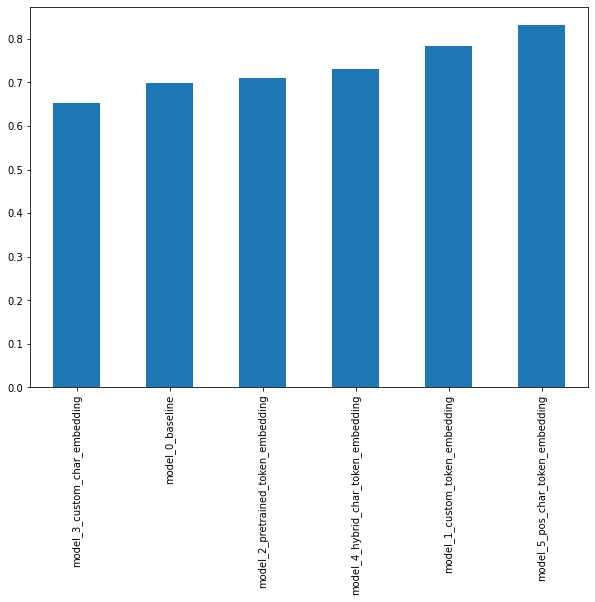

In [124]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));
   

## Save and load model

In [126]:
# Save the best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

In [127]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")
     

# Make predictions with the loaded moel on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 26s 24ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [128]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results
     

{'accuracy': 83.29802727393088,
 'precision': 0.8316114344747414,
 'recall': 0.8329802727393089,
 'f1': 0.8320142170655527}

In [129]:
assert model_5_results == loaded_model_results
     

# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t